# Set up and Import

In [22]:
import scipy.io as scio
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from scipy.io import loadmat
import scipy

In [2]:
conda install keras

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [15]:
import tensorflow
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.utils import to_categorical

# Feature Extraction

### Method I

In [28]:
class load():
    def load_data(filename):
        raw_data = pd.read_csv(filename)
        raw_data['filename'] = [str(i).zfill(4)+'.jpg' for i in raw_data['Index'].tolist()]
        raw_data['pointsname'] = [str(i).zfill(4)+'.mat' for i in raw_data['Index'].tolist()]
        return raw_data

    #read points data from mat data
    def load_points(points_path,data):
        n = data.shape[0]
        points_data = np.zeros([n,3003,2])
        start_time = time.time()
        for i in range(n):
            result = loadmat(points_path+data['pointsname'][i])
            key = sorted(result.keys())[-1]
            points = result[key]
            distance_h = []
            distance_v = []
            for d in range(points.shape[0]-1):
                for j in range(d+1,points.shape[0]):
                    distance_h.append(abs(points[d,0]-points[j,0]))
                    distance_v.append(abs(points[d,1]-points[j,1]))

            points_data[i,:,0]=distance_h
            points_data[i,:,1]=distance_v
        print("--- %s seconds ---" % (time.time() - start_time))
        return points_data.reshape([2500,6006])

In [29]:
path = '/Users/zhaoziqin/Desktop/train_set/'
data = load.load_data(path+'label.csv')
points_path = '/Users/zhaoziqin/Desktop/train_set/points/'
X = load.load_points(points_path,data)
y= data['emotion_idx'].to_numpy()

--- 14.409195899963379 seconds ---


### Method II

In [27]:
filepath = '/Users/zhaoziqin/Desktop/Applied Data Science/Spring2020-Project3-group5/'

os.chdir(filepath)

# testpath=filepath+'/data/test_set/'
trainpath=filepath+'/data/train_set/'

# test_image_dir = testpath + "images/"
# test_pt_dir = testpath + "points/"
train_image_dir = trainpath + "images/"
train_pt_dir = trainpath + "points/"

import sklearn.metrics.pairwise
def pairwise_dist(vec):
    dist  = sklearn.metrics.pairwise_distances(vec, metric='euclidean')
    np.fill_diagonal(dist, np.nan)
    return dist
def feature(fiducial_pt_list,index):
    pairwise_dist_feature = pairwise_dist(fiducial_pt_list[index]).flatten()
    pairwise_dist_feature = pairwise_dist_feature[~np.isnan(pairwise_dist_feature)]
    return pairwise_dist_feature

f0 = time.time()
dataDir = train_pt_dir
fiducial_pt_list = []
filelist = []
for file in os.listdir(dataDir):
    filelist.append(file)
filelist.sort()
for file in filelist:
    fiducial_pt_list.append(scipy.io.loadmat(dataDir+file))
    l = []
for i in range(len(fiducial_pt_list)):
    if 'faceCoordinatesUnwarped' in fiducial_pt_list[i].keys():
        l.append(fiducial_pt_list[i]['faceCoordinatesUnwarped'])
    else:
        l.append(fiducial_pt_list[i]['faceCoordinates2'])
        
fiducial_pt_list = l


X = pd.DataFrame(np.zeros((2500, 6006)))
for i in range(2500):
    X.iloc[i,:] = np.round(feature(fiducial_pt_list, i).flatten(), 0)
y =pd.read_csv(trainpath+'label.csv')['emotion_idx']
f1 = time.time()-f0

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Advanced Model --- Neutral Network

### Method II for NN Fitting

In [17]:
Y = to_categorical(y)
Y = Y[:,1:]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)

In [18]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)

In [19]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(X_train,y_train,epochs=200)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/200
2000/2000 [==============================] - 7s 4ms/step - loss: 3.0633 - accuracy: 0.0790
Epoch 2/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6934 - accuracy: 0.1565
Epoch 3/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.3541 - accuracy: 0.2325
Epoch 4/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.2221 - accuracy: 0.2600
Epoch 5/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.0922 - accuracy: 0.2945
Epoch 6/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.0296 - accuracy: 0.3180
Epoch 7/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.9960 - accuracy: 0.3255
Epoch 8/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.9144 - accuracy: 0.3530
Epoch 9/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.8671 - accuracy: 0.3590
Epoch 10/200
2000/2000 [==============================] - 4s 2ms/step - l

2000/2000 [==============================] - 4s 2ms/step - loss: 0.8220 - accuracy: 0.7095
Epoch 80/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8085 - accuracy: 0.7180
Epoch 81/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8153 - accuracy: 0.7145
Epoch 82/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8446 - accuracy: 0.7145
Epoch 83/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8257 - accuracy: 0.7155
Epoch 84/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8208 - accuracy: 0.7165
Epoch 85/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7714 - accuracy: 0.7280
Epoch 86/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8388 - accuracy: 0.7040
Epoch 87/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7872 - accuracy: 0.7225
Epoch 88/200
2000/2000 [==============================] - 4s 2ms/step - loss:

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5019 - accuracy: 0.8270
Epoch 158/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4706 - accuracy: 0.8405
Epoch 159/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5141 - accuracy: 0.8235
Epoch 160/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5324 - accuracy: 0.8190
Epoch 161/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5112 - accuracy: 0.8280
Epoch 162/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4500 - accuracy: 0.8445
Epoch 163/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4662 - accuracy: 0.8385
Epoch 164/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5349 - accuracy: 0.8230
Epoch 165/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5125 - accuracy: 0.8320
Epoch 166/200
2000/2000 [==============================] - 4s 2ms/ste

Text(0.5, 1.0, 'Accuracy Curves')

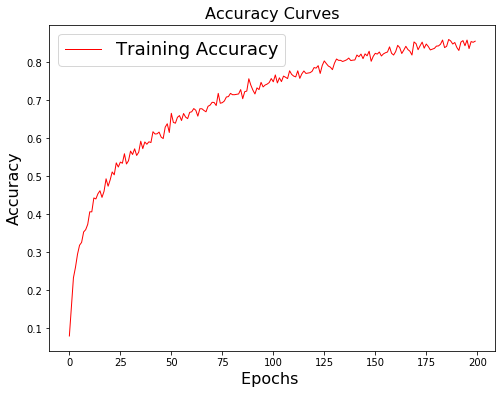

In [20]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [23]:
start = time.time()
pred = model.predict(X_test)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(y_test, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))

Test accuracy is 54.8 percent
testing model takes 0.28 seconds


### Method I for NN fitting

In [30]:
Y = to_categorical(y)
Y = Y[:,1:]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1106)

In [31]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)

In [32]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(X_train,y_train,epochs=200)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/200
2000/2000 [==============================] - 7s 4ms/step - loss: 3.0503 - accuracy: 0.0795
Epoch 2/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6699 - accuracy: 0.1765
Epoch 3/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.3164 - accuracy: 0.2765
Epoch 4/200
2000/2000 [==============================] - 5s 3ms/step - loss: 2.0801 - accuracy: 0.3075
Epoch 5/200
2000/2000 [==============================] - 5s 3ms/step - loss: 1.9558 - accuracy: 0.3455
Epoch 6/200
2000/2000 [==============================] - 5s 2ms/step - loss: 1.8573 - accuracy: 0.3635
Epoch 7/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7954 - accuracy: 0.3990
Epoch 8/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.6877 - accuracy: 0.4415
Epoch 9/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.6597 - accuracy: 0.4410
Epoch 10/200
2000/2000 [==============================] - 4s 2ms/step - l

2000/2000 [==============================] - 4s 2ms/step - loss: 0.4411 - accuracy: 0.8465
Epoch 80/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4395 - accuracy: 0.8480
Epoch 81/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4666 - accuracy: 0.8340
Epoch 82/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4646 - accuracy: 0.8440
Epoch 83/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4766 - accuracy: 0.8350
Epoch 84/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4773 - accuracy: 0.8405
Epoch 85/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4519 - accuracy: 0.8485
Epoch 86/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4168 - accuracy: 0.8645
Epoch 87/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4490 - accuracy: 0.8540
Epoch 88/200
2000/2000 [==============================] - 4s 2ms/step - loss:

2000/2000 [==============================] - 4s 2ms/step - loss: 0.2614 - accuracy: 0.9155
Epoch 157/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2438 - accuracy: 0.9215
Epoch 158/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2349 - accuracy: 0.9260
Epoch 159/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2095 - accuracy: 0.9360
Epoch 160/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2110 - accuracy: 0.9320
Epoch 161/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2436 - accuracy: 0.9130
Epoch 162/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2252 - accuracy: 0.9290
Epoch 163/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2262 - accuracy: 0.9270
Epoch 164/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2263 - accuracy: 0.9275
Epoch 165/200
2000/2000 [==============================] - 4s 2ms/ste

Text(0.5, 1.0, 'Accuracy Curves')

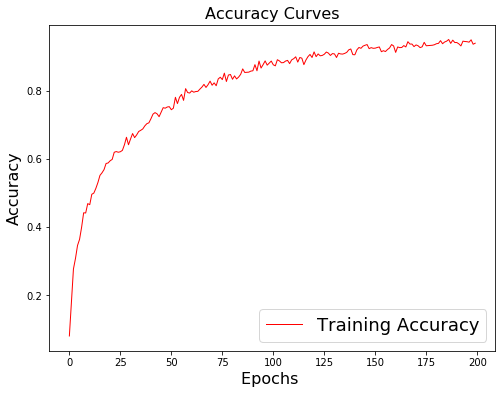

In [33]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [35]:
start = time.time()
pred = model.predict(X_test)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(y_test, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))

Test accuracy is 55.0 percent
testing model takes 0.286 seconds
